<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **FINAL PROJECT**
# **American Option Portfolio Value-at-Risk (VaR)**

### **INTRODUCTION**
  ▶ What is an **option**?
  
  An option is a financial contract that gives someone the right (but not the obligation) to buy or sell something in the future, like a stock.

  - A call option = right to buy

  - A put option = right to sell


▶ What is an **American Option**?

There are two main types:

  - European option: can only be exercised at the end

  - American option: can be exercised at any time before or on the expiration date


▶  Why are American Options **harder to value**?

Because we do not know when the holder will choose to exercise it. We need a smart way to decide if holding the option is better than using it right now.


▶  We introduce: **Longstaff-Schwartz Algorithm**

This algorithm helps us estimate the best time to exercise an American option.
It works like this:
  
  1. Simulate multiple price paths for the underlying stock.

  2. At each time step, calculate:

    - The immediate payoff from exercising

    - The expected value of holding it longer (using regression)

    - Exercise the option if it is better than holding it.

  3. Repeat for many paths and average results to estimate the option’s value.

▶ **Portfolio** VaR calculation

We will follow this steps in this project:

  1. Simulating portfolio values under many market conditions.

  2. Calculating the distribution of possible profits and losses (P&L).

  3. Taking the 5th percentile (for 95% VaR) — this is the estimated worst loss.


**DATA**:

We will use SPY ticker, because:

- It’s a real security

- You can get actual option prices for validation

- American options exist and trade on SPY (but not on ^GSPC)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


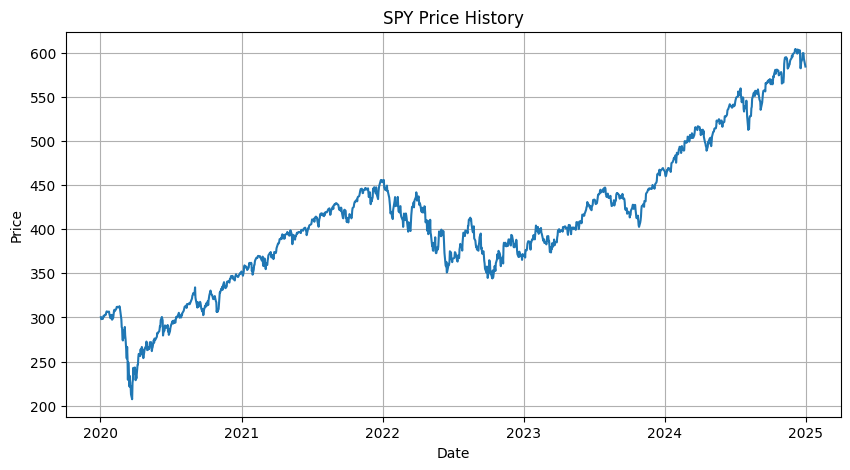

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ticker = 'SPY'
start_date = '2020-01-01'
end_date = '2025-01-01'

spy_data = yf.download(ticker, start=start_date, end=end_date)
spy_data = spy_data[['Close']].rename(columns={'Close': 'Price'})

plt.figure(figsize=(10, 5))
plt.plot(spy_data.index, spy_data['Price'])
plt.title('SPY Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


Annualized Mean Return (mu): 0.1335
Annualized Volatility (sigma): 0.2108


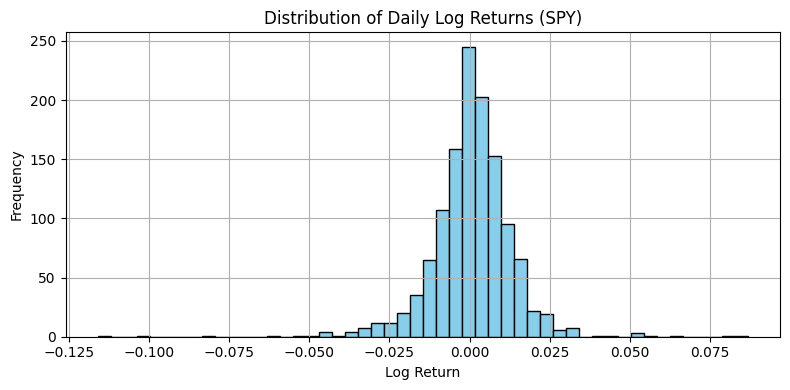

In [3]:
spy_data['LogReturn'] = np.log(spy_data['Price'] / spy_data['Price'].shift(1))
spy_data.dropna(inplace=True)

mu_daily = spy_data['LogReturn'].mean()
sigma_daily = spy_data['LogReturn'].std()

mu_annual = mu_daily * 252
sigma_annual = sigma_daily * np.sqrt(252)

print(f"Annualized Mean Return (mu): {mu_annual:.4f}")
print(f"Annualized Volatility (sigma): {sigma_annual:.4f}")

plt.figure(figsize=(8, 4))
plt.hist(spy_data['LogReturn'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Daily Log Returns (SPY)")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#**PRELIMINAR ANALYSIS**
On the one hand, a mean return of aprox 13.35% is a reasonable average annual return as the long term average for the S&P 500 is usually around 7%–10% (after inflation). Also some recent 5-year windows (like post-COVID recovery) have been higher — so 13% is very plausible.

On the other hand, volatility is of aprox 21.08%. This is also a realistic result, as SPY's volatility usually ranges between 15%–25% annually. Events like COVID crash (2020), inflation spikes (2022) and tech growth rebound (2023–2024) all contribute to volatility in your 5-year window.

#**IMPLEMENTATION**
**Monte Carlo Simulation (using GBM)**

We simulate future asset prices by generating multiple random paths based on the Geometric Brownian Motion (GBM) model:

$$
S_{t+\Delta t} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \cdot \sqrt{\Delta t} \cdot Z_t\right]
$$

Where:
- $ S_t $: asset price at time $ t $
- $ \mu $: expected return
- $ \sigma $: volatility
- $ \Delta t $: time step (1/252 for daily simulation)
- $ Z_t \sim \mathcal{N}(0, 1) $: standard normal random variable

This method generates multiple possible price paths to estimate the future distribution of asset prices.


In [9]:
S0 = spy_data['Price'].iloc[-1]
print(S0)
mu = mu_annual
sigma = sigma_annual

T = 1
N = 252
dt = T / N
n_paths = 50000

np.random.seed(42)
Z = np.random.standard_normal((N, n_paths))

price_paths = np.zeros((N + 1, n_paths))
price_paths[0] = S0

# Apply GBM formula to simulate paths
for t in range(1, N + 1):
    price_paths[t] = price_paths[t - 1] * np.exp(
        (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t - 1]
    )

simulated_prices = pd.DataFrame(price_paths)
simulated_prices.head()

Ticker
SPY    584.322266
Name: 2024-12-31 00:00:00, dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
0,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,...,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266
1,588.449545,583.507720,589.630674,596.525664,582.765063,582.765190,596.970956,590.569179,580.946515,588.807964,...,586.114809,578.877337,581.928662,596.423394,565.601454,585.021400,584.386766,588.475890,586.643039,596.468474
2,589.477713,583.268494,597.395293,609.063208,588.365245,590.908167,595.512505,591.814799,592.785689,593.203220,...,591.409856,585.520723,580.538068,598.386710,575.823934,583.531528,580.237145,591.943959,585.258886,597.684131
3,597.865740,574.640194,602.244269,604.341231,586.070971,591.542937,594.830656,579.041319,604.031862,602.474391,...,602.200880,582.469049,589.830231,609.576069,570.003961,589.860924,581.981407,590.805054,586.697296,604.077306
4,609.111737,574.067829,593.905034,615.889644,585.449027,587.631125,602.155374,583.525598,605.287787,597.997183,...,591.914221,585.699515,583.826811,616.913919,565.800813,580.292916,586.629043,592.323426,593.664934,595.856222


#**SETTINGS**
- Option type: put
- Strike price: 600

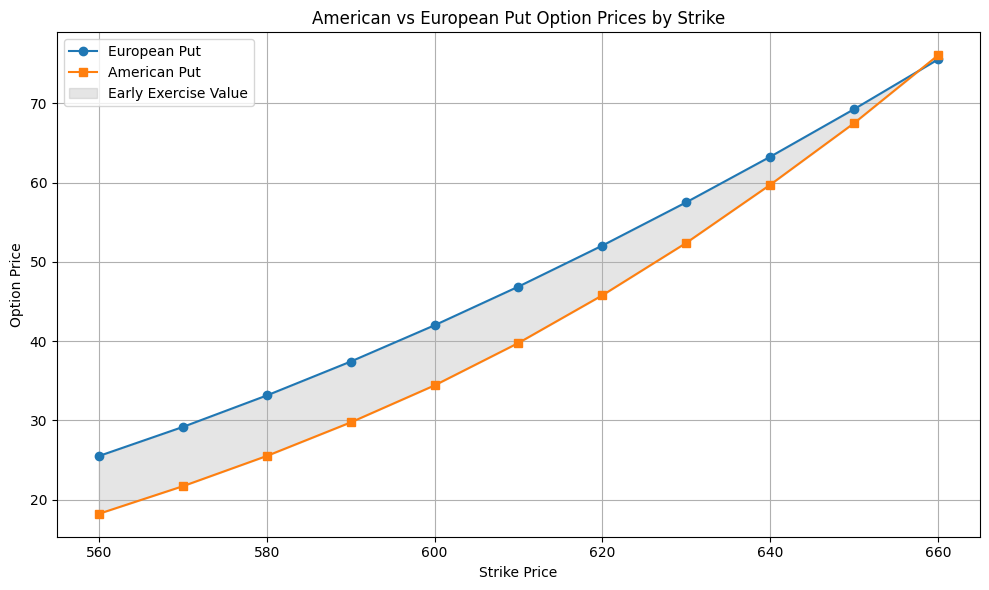

In [19]:
import numpy as np

def price_american_put_longstaff(S, K, r=0.05, T=1, N=252):
    dt = T / N
    discount = np.exp(-r * dt)
    n_paths = S.shape[1]

    payoffs = np.maximum(K - S[-1], 0)

    for t in range(N - 1, 0, -1):
        itm = np.where(K - S[t] > 0)[0]
        if len(itm) == 0:
            continue

        X = S[t, itm]
        Y = payoffs[itm] * discount

        # Regression (can reduce to X, X^2 to prevent overfitting)
        A = np.vstack([np.ones(len(X)), X, X**2]).T
        coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
        continuation = coeffs[0] + coeffs[1]*X + coeffs[2]*X**2

        exercise = K - X
        exercise_now = exercise > continuation

        # Update payoff where early exercise is better
        update_indices = itm[exercise_now]
        payoffs[update_indices] = exercise[exercise_now]

        # Discount only paths that were NOT exercised now
        not_exercised = np.ones(n_paths, dtype=bool)
        not_exercised[update_indices] = False
        payoffs[not_exercised] *= discount

    return np.mean(payoffs)


def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

strike_range = np.arange(560, 670, 10)

american_prices = []
european_prices = []

for K in strike_range:
    european_prices.append(black_scholes_put(S0, K, T, r, sigma))
    american_prices.append(price_american_put_longstaff(price_paths, K, r, T, N))

european_prices = np.array(european_prices).flatten()
american_prices = np.array(american_prices).flatten()
plt.figure(figsize=(10, 6))
plt.plot(strike_range, european_prices, label="European Put", marker='o')
plt.plot(strike_range, american_prices, label="American Put", marker='s')
plt.fill_between(strike_range, european_prices, american_prices, alpha=0.2, color='gray', label="Early Exercise Value")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("American vs European Put Option Prices by Strike")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#**ANALYSIS**
If we wanted to sell this American put option today in the market, based on our simulation model, we would expect to receive about $36.11 per option.

This is due to the fact that the option is already worth at least $15.68 right now (just from being in-the-money: 600 - 584.32). It could become even more valuable if SPY drops further. Since it is an American option, you could also choose to exercise early and lock in profit.

So our model tells us that taking all of that into account (early exercise, future drops, and time value) this option is worth $36.11 today.

In [15]:
import numpy as np
from scipy.stats import norm

def black_scholes_put(S, K, T, r, sigma):
    """
    Calculate the price of a European put option using the Black-Scholes formula.

    Parameters:
    - S: Current price of the underlying asset
    - K: Strike price of the option
    - T: Time to maturity (in years)
    - r: Risk-free interest rate (annualized)
    - sigma: Volatility of the underlying asset (annualized)

    Returns:
    - Price of the European put option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# === Example Parameters ===
S = 584.32      # Current SPY price
K = 700         # Strike price
T = 1           # Time to maturity (1 year)
r = 0.05        # Risk-free interest rate (5%)
sigma = 0.2108  # Annualized volatility (from historical data)

# === Compute European Put Price ===
european_put = black_scholes_put(S, K, T, r, sigma)
print(f"European Put Option Price: ${european_put:.4f}")


European Put Option Price: $102.9526


#**References**
[1] Glasserman, Monte Carlo Methods in Financial Engineering, Ch. 8

[2] Palczewski, Computational Finance Lecture Notes, Ch. 8

[3] McNeil, Frey, Embrechts, Quantitative Risk Management (for risk metrics background)